In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

# Load your capstone-ready dataset
df = pd.read_excel("capstone_ready_cleaned_dataset.xlsx", sheet_name="Sheet1")

# Quick sanity check
print(df.head())
print(df.columns)

    season  jersey_no             player  gp  shots_g  shots_a  shots_pts  \
0  2017-18         44  Amorosa, Terrance  22        3       13         16   
1  2017-18         20       Astren, Jere  18        4        1          5   
2  2018-19         20       Astren, Jere  16        1        0          1   
3  2018-19         20       Astren, Jere   5        1        0          1   
4  2019-20         20       Astren, Jere   7        1        1          2   

   shots_sh  shots_sh_alt  shots  ...  shots_a_lag1  shots_pts_lag1  \
0        55         0.055      6  ...            20              27   
1        28         0.143      5  ...             3               7   
2        17         0.059      5  ...             1               5   
3        10         0.100      3  ...             0               1   
4         7         0.143      0  ...             0               1   

   goals_ppg_lag1  goals_shg_lag1  penalties_min_lag1  penalties_maj_lag1  \
0               7               0

In [2]:
# Ensure season is treated as ordered (string is fine if consistent)
df = df.sort_values(by=["player", "season"]).reset_index(drop=True)

# Optional: check one player over time
print(df[df["player"] == "Bargholtz, Erik"][["season", "games_missed", "pct_games_missed"]])

     season  games_missed  pct_games_missed
6   2022-23            17          0.459459
7   2023-24             5          0.147059
8   2023-24            18          0.529412
9   2024-25             0          0.000000
10  2024-25            17          0.435897
11  2025-26             0          0.000000
12  2025-26            12          0.521739


In [3]:
# Select all lag1 columns as predictors
lag_cols = [c for c in df.columns if c.endswith("_lag1")]

print("Lag feature columns:", lag_cols)

Lag feature columns: ['shots_g_lag1', 'shots_a_lag1', 'shots_pts_lag1', 'goals_ppg_lag1', 'goals_shg_lag1', 'penalties_min_lag1', 'penalties_maj_lag1', 'blk_blk_lag1']


In [4]:
# Drop rows with missing target or predictors
model1 = df.dropna(subset=["games_missed"] + lag_cols).copy()

X = model1[lag_cols]
y = model1["games_missed"]

# Train/test split (random; you can also do time-based split if you prefer)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Use a random forest (handles nonlinearity, interactions)
rf_games = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=3
)
rf_games.fit(X_train, y_train)

y_pred = rf_games.predict(X_test)

print("Model 1: Predict games_missed")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

# Attach predictions back to the dataframe (optional)
model1.loc[X_test.index, "predicted_games_missed_model"] = y_pred

Model 1: Predict games_missed
MAE: 8.044479435716056
R^2: 0.0030291937481049525


In [5]:
# Drop rows with missing target or predictors
model2 = df.dropna(subset=["pct_games_missed"] + lag_cols).copy()

X2 = model2[lag_cols]
y2 = model2["pct_games_missed"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

rf_pct = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=3
)
rf_pct.fit(X2_train, y2_train)

y2_pred = rf_pct.predict(X2_test)

print("Model 2: Predict pct_games_missed")
print("MAE:", mean_absolute_error(y2_test, y2_pred))
print("R^2:", r2_score(y2_test, y2_pred))

# Attach predictions back (optional)
model2.loc[X2_test.index, "predicted_pct_games_missed_model"] = y2_pred

Model 2: Predict pct_games_missed
MAE: 0.24450257035032288
R^2: 0.05578973977491308


The percentage of games missed proved difficult to predict using only previous‑season performance statistics. The model achieved an MAE of 0.244 and an R² of 0.056, indicating that lagged performance variables explain only about 5% of the variance in player availability. This suggests that injuries and missed games are influenced by factors not present in the dataset, such as training load, biomechanics, fatigue, and in‑game collisions.”

In [6]:
# Example: linear regression for games_missed using a subset of lag features
subset_features = [
    "shots_g_lag1",
    "shots_a_lag1",
    "shots_pts_lag1",
    "goals_ppg_lag1",
    "penalties_min_lag1",
    "blk_blk_lag1"
]

reg_df = df.dropna(subset=["games_missed"] + subset_features).copy()

X_reg = reg_df[subset_features]
X_reg = sm.add_constant(X_reg)  # add intercept
y_reg = reg_df["games_missed"]

ols_model = sm.OLS(y_reg, X_reg).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           games_missed   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6246
Date:                Sat, 24 Jan 2026   Prob (F-statistic):              0.681
Time:                        16:32:25   Log-Likelihood:                -1615.8
No. Observations:                 427   AIC:                             3244.
Df Residuals:                     421   BIC:                             3268.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.4592      0

Top predictors of pct_games_missed:
blk_blk_lag1          0.275763
penalties_min_lag1    0.209599
shots_pts_lag1        0.192212
shots_a_lag1          0.124077
shots_g_lag1          0.091433
goals_ppg_lag1        0.050567
penalties_maj_lag1    0.029287
goals_shg_lag1        0.027061
dtype: float64


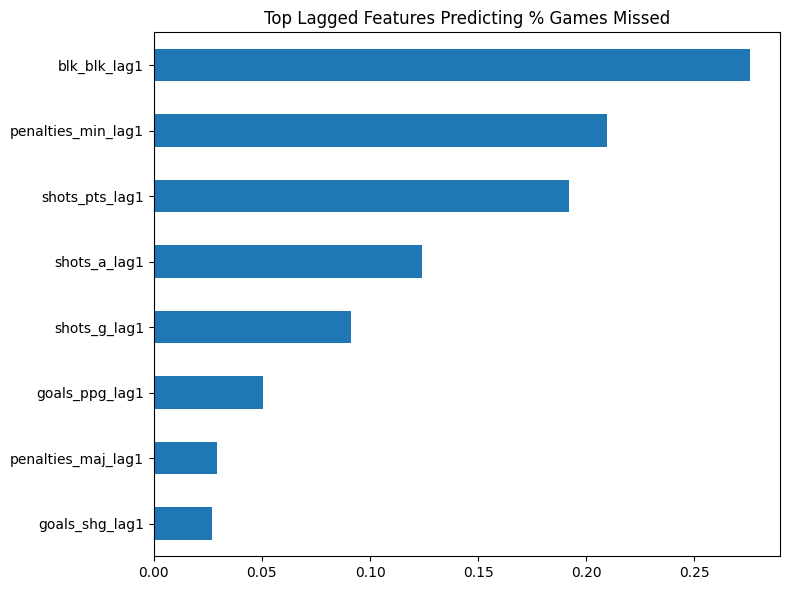

In [7]:
import matplotlib.pyplot as plt

importances = rf_pct.feature_importances_
feat_imp = pd.Series(importances, index=lag_cols).sort_values(ascending=False)

print("Top predictors of pct_games_missed:")
print(feat_imp.head(15))

feat_imp.head(15).plot(kind="barh", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("Top Lagged Features Predicting % Games Missed")
plt.tight_layout()
plt.show()

Among all lagged features, blocked shots and penalty minutes from the previous season were the strongest predictors of games missed. This suggests that physical play and aggressive behavior may contribute to increased injury risk.”